In [9]:
# Experiment 2 KD with a smaller model as student

In [1]:
# Split the training data into validation set and training set use a stratified k fold 
import numpy as np
import pandas as pd
import sklearn

from sklearn import tree
from sklearn.metrics import r2_score
from sklearn.preprocessing import RobustScaler, QuantileTransformer 

from sklearn.model_selection import StratifiedKFold, KFold

In [2]:
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
from tensorflow.keras import datasets, layers, models, losses

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [3]:
# Knowledge distillation 
# Modified from source: https://keras.io/examples/vision/knowledge_distillation/

import Distiller

In [4]:
# Load the saved dataset
# Source: https://scikit-learn.org/stable/modules/generated/sklearn.datasets.fetch_california_housing.html
california_housing_data_train = pd.read_csv('Data/california_housing_train.txt')
california_housing_data_test = pd.read_csv('Data/california_housing_test.txt')

# This dataset have strong outliers due to the hard limit of the housing price
# remove those from the training set
california_housing_data_train = california_housing_data_train[california_housing_data_train['MedHouseVal'] < 5]  


In [5]:
# Set up the datasets
x_train = california_housing_data_train.iloc[:,0:7].to_numpy()
y_train = california_housing_data_train.iloc[:,-1].to_numpy()

x_test = california_housing_data_test.iloc[:,0:7].to_numpy()
y_test = california_housing_data_test.iloc[:,-1].to_numpy()

In [6]:
# Build the student model

def buildStudentModel():
    model = models.Sequential()
    
    model.add(layers.Dense(4096, activation='relu'))
    
    model.add(layers.Dense(1024, activation='relu'))
        
    model.add(layers.Dense(8, activation='relu'))
    model.add(layers.Dense(1))    
    
    return model

In [7]:
# Construct/load models

teacher_model = tf.keras.models.load_model('MlpTeacherModel/MlpTeacherModel')

# Perform the 10 fold cross validation
number_of_folds = 10

skf = KFold(n_splits=number_of_folds)

In [8]:
# Haperparameter used in the experiment
number_of_epochs = 100

train_val_results_with_distillation = []
train_val_results_without_distillation = []

test_results_with_distillation = []
test_results_without_distillation = []

for i, (train_index, val_index) in enumerate(skf.split(x_train, y_train)):
    print(f"Fold {i}")
    
    studnet_model = buildStudentModel()
    studnet_model_without_distillation = keras.models.clone_model(studnet_model)
    
    x_train_fold = x_train[train_index]
    y_train_fold = y_train[train_index]
    
    x_val_fold = x_train[val_index]
    y_val_fold = y_train[val_index]
    
    distiller = Distiller.Distiller(student=studnet_model, teacher=teacher_model)
    distiller.compile(
        optimizer=keras.optimizers.Adam(),
        metrics=['mse', 'mae', 'mape'],
        student_loss_fn=tf.keras.losses.MeanAbsoluteError(),
        distillation_loss_fn=distiller.mse_distillation_loss_fucntion,
        alpha=0.1,
        temperature=10        
    )
    # Distill teacher to student
    history = distiller.fit(
        x_train_fold, 
        y_train_fold, 
        epochs=number_of_epochs,
        validation_data=(x_val_fold, y_val_fold)
    )
    train_val_results_with_distillation.append(history.history)
    
    # Train and evaluate the student model without distillation
    studnet_model_without_distillation.compile(
        optimizer=keras.optimizers.Adam(),
        loss=tf.keras.losses.MeanAbsoluteError(),
        metrics=['mse', 'mae', 'mape'],
    )

    # Train and evaluate student trained from scratch.
    history = studnet_model_without_distillation.fit(
        x_train_fold, 
        y_train_fold,
        epochs=number_of_epochs,
        validation_data=(x_val_fold, y_val_fold)
    )
    train_val_results_without_distillation.append(history.history)
    
print('Training done')

Fold 0
Epoch 1/100
443/443 [==============================] - 2s 3ms/step - mse: 1431.1372 - mae: 7.7683 - mape: 508.7203 - student_loss: 7.7399 - distillation_loss: 1425.2035 - val_mse: 1.1975 - val_mae: 0.7717 - val_mape: 41.2571 - val_student_loss: 1.0572
Epoch 2/100
443/443 [==============================] - 1s 3ms/step - mse: 1.7430 - mae: 0.9029 - mape: 60.7660 - student_loss: 0.9056 - distillation_loss: 1.2865 - val_mse: 0.7701 - val_mae: 0.6622 - val_mape: 43.6150 - val_student_loss: 0.9353
Epoch 3/100
443/443 [==============================] - 1s 3ms/step - mse: 1.1104 - mae: 0.7620 - mape: 51.2433 - student_loss: 0.7605 - distillation_loss: 0.6623 - val_mse: 1.8145 - val_mae: 1.0392 - val_mape: 52.2909 - val_student_loss: 1.0441
Epoch 4/100
443/443 [==============================] - 1s 2ms/step - mse: 1.1899 - mae: 0.7603 - mape: 50.9375 - student_loss: 0.7602 - distillation_loss: 0.7602 - val_mse: 0.8846 - val_mae: 0.6049 - val_mape: 36.5985 - val_student_loss: 0.7524
Epoch 

443/443 [==============================] - 1s 2ms/step - mse: 0.9537 - mae: 0.7828 - mape: 55.9645 - student_loss: 0.7824 - distillation_loss: 0.5153 - val_mse: 0.9325 - val_mae: 0.7728 - val_mape: 57.0189 - val_student_loss: 1.1460
Epoch 35/100
443/443 [==============================] - 1s 2ms/step - mse: 0.9538 - mae: 0.7828 - mape: 55.9702 - student_loss: 0.7841 - distillation_loss: 0.5153 - val_mse: 0.9325 - val_mae: 0.7735 - val_mape: 57.2110 - val_student_loss: 1.1471
Epoch 36/100
443/443 [==============================] - 1s 3ms/step - mse: 0.9537 - mae: 0.7832 - mape: 56.0656 - student_loss: 0.7835 - distillation_loss: 0.5180 - val_mse: 0.9325 - val_mae: 0.7723 - val_mape: 56.8800 - val_student_loss: 1.1452
Epoch 37/100
443/443 [==============================] - 1s 2ms/step - mse: 0.9537 - mae: 0.7828 - mape: 55.9597 - student_loss: 0.7821 - distillation_loss: 0.5141 - val_mse: 0.9325 - val_mae: 0.7722 - val_mape: 56.8489 - val_student_loss: 1.1451
Epoch 38/100
443/443 [=======

443/443 [==============================] - 1s 3ms/step - mse: 0.9538 - mae: 0.7832 - mape: 56.0515 - student_loss: 0.7836 - distillation_loss: 0.5149 - val_mse: 0.9325 - val_mae: 0.7728 - val_mape: 57.0152 - val_student_loss: 1.1460
Epoch 68/100
443/443 [==============================] - 1s 3ms/step - mse: 0.9536 - mae: 0.7830 - mape: 56.0255 - student_loss: 0.7829 - distillation_loss: 0.5171 - val_mse: 0.9325 - val_mae: 0.7724 - val_mape: 56.9208 - val_student_loss: 1.1455
Epoch 69/100
443/443 [==============================] - 1s 3ms/step - mse: 0.9539 - mae: 0.7826 - mape: 55.9059 - student_loss: 0.7807 - distillation_loss: 0.5141 - val_mse: 0.9325 - val_mae: 0.7736 - val_mape: 57.2457 - val_student_loss: 1.1472
Epoch 70/100
443/443 [==============================] - 1s 3ms/step - mse: 0.9538 - mae: 0.7832 - mape: 56.0525 - student_loss: 0.7822 - distillation_loss: 0.5157 - val_mse: 0.9325 - val_mae: 0.7728 - val_mape: 57.0285 - val_student_loss: 1.1461
Epoch 71/100
443/443 [=======

443/443 [==============================] - 1s 3ms/step - mse: 0.9537 - mae: 0.7828 - mape: 55.9690 - student_loss: 0.7842 - distillation_loss: 0.5146 - val_mse: 0.9325 - val_mae: 0.7737 - val_mape: 57.2893 - val_student_loss: 1.1475
Epoch 1/100
443/443 [==============================] - 1s 2ms/step - loss: 1.9497 - mse: 26.7851 - mae: 1.9497 - mape: 101.3691 - val_loss: 1.4792 - val_mse: 3.1189 - val_mae: 1.4792 - val_mape: 69.9712
Epoch 2/100
443/443 [==============================] - 1s 2ms/step - loss: 1.2977 - mse: 2.6155 - mae: 1.2977 - mape: 58.3319 - val_loss: 1.1151 - val_mse: 2.0778 - val_mae: 1.1151 - val_mape: 49.5963
Epoch 3/100
443/443 [==============================] - 1s 2ms/step - loss: 1.0124 - mse: 1.8019 - mae: 1.0124 - mape: 45.5972 - val_loss: 0.9132 - val_mse: 1.4918 - val_mae: 0.9132 - val_mape: 44.1011
Epoch 4/100
443/443 [==============================] - 1s 2ms/step - loss: 0.8662 - mse: 1.3614 - mae: 0.8662 - mape: 43.4604 - val_loss: 0.8169 - val_mse: 1.1875

443/443 [==============================] - 1s 2ms/step - loss: 0.7706 - mse: 0.9891 - mae: 0.7706 - mape: 50.2856 - val_loss: 0.7629 - val_mse: 0.9619 - val_mae: 0.7629 - val_mape: 51.4609
Epoch 41/100
443/443 [==============================] - 1s 2ms/step - loss: 0.7706 - mse: 0.9885 - mae: 0.7706 - mape: 50.3451 - val_loss: 0.7628 - val_mse: 0.9608 - val_mae: 0.7628 - val_mape: 51.5523
Epoch 42/100
443/443 [==============================] - 1s 2ms/step - loss: 0.7706 - mse: 0.9894 - mae: 0.7706 - mape: 50.2782 - val_loss: 0.7629 - val_mse: 0.9613 - val_mae: 0.7629 - val_mape: 51.5079
Epoch 43/100
443/443 [==============================] - 1s 2ms/step - loss: 0.7706 - mse: 0.9875 - mae: 0.7706 - mape: 50.4245 - val_loss: 0.7629 - val_mse: 0.9623 - val_mae: 0.7629 - val_mape: 51.4246
Epoch 44/100
443/443 [==============================] - 1s 2ms/step - loss: 0.7706 - mse: 0.9897 - mae: 0.7706 - mape: 50.2458 - val_loss: 0.7628 - val_mse: 0.9605 - val_mae: 0.7628 - val_mape: 51.5802
Epo

Epoch 81/100
443/443 [==============================] - 1s 2ms/step - loss: 0.7706 - mse: 0.9879 - mae: 0.7706 - mape: 50.3903 - val_loss: 0.7629 - val_mse: 0.9619 - val_mae: 0.7629 - val_mape: 51.4628
Epoch 82/100
443/443 [==============================] - 1s 2ms/step - loss: 0.7706 - mse: 0.9893 - mae: 0.7706 - mape: 50.2663 - val_loss: 0.7628 - val_mse: 0.9602 - val_mae: 0.7628 - val_mape: 51.6049
Epoch 83/100
443/443 [==============================] - 1s 2ms/step - loss: 0.7705 - mse: 0.9903 - mae: 0.7705 - mape: 50.1976 - val_loss: 0.7628 - val_mse: 0.9591 - val_mae: 0.7628 - val_mape: 51.7048
Epoch 84/100
443/443 [==============================] - 1s 2ms/step - loss: 0.7706 - mse: 0.9871 - mae: 0.7706 - mape: 50.4412 - val_loss: 0.7628 - val_mse: 0.9609 - val_mae: 0.7628 - val_mape: 51.5463
Epoch 85/100
443/443 [==============================] - 1s 2ms/step - loss: 0.7706 - mse: 0.9882 - mae: 0.7706 - mape: 50.3578 - val_loss: 0.7629 - val_mse: 0.9614 - val_mae: 0.7629 - val_mape

Epoch 18/100
443/443 [==============================] - 1s 2ms/step - mse: 0.6336 - mae: 0.5913 - mape: 38.9909 - student_loss: 0.5920 - distillation_loss: 0.2111 - val_mse: 0.4644 - val_mae: 0.5174 - val_mape: 32.2828 - val_student_loss: 0.3310
Epoch 19/100
443/443 [==============================] - 1s 3ms/step - mse: 0.5146 - mae: 0.5413 - mape: 35.0026 - student_loss: 0.5410 - distillation_loss: 0.1012 - val_mse: 0.4681 - val_mae: 0.5100 - val_mape: 30.5999 - val_student_loss: 0.2736
Epoch 20/100
443/443 [==============================] - 1s 2ms/step - mse: 0.9893 - mae: 0.6604 - mape: 43.3669 - student_loss: 0.6594 - distillation_loss: 0.5620 - val_mse: 0.5053 - val_mae: 0.5264 - val_mape: 30.7455 - val_student_loss: 0.2324
Epoch 21/100
443/443 [==============================] - 1s 3ms/step - mse: 0.5060 - mae: 0.5393 - mape: 35.2188 - student_loss: 0.5406 - distillation_loss: 0.0890 - val_mse: 0.4611 - val_mae: 0.5186 - val_mape: 32.9623 - val_student_loss: 0.3439
Epoch 22/100
443

443/443 [==============================] - 1s 2ms/step - mse: 0.4166 - mae: 0.4850 - mape: 31.4972 - student_loss: 0.4851 - distillation_loss: 0.0275 - val_mse: 0.3760 - val_mae: 0.4609 - val_mape: 29.0591 - val_student_loss: 0.2380
Epoch 52/100
443/443 [==============================] - 1s 3ms/step - mse: 0.3965 - mae: 0.4711 - mape: 30.5812 - student_loss: 0.4711 - distillation_loss: 0.0124 - val_mse: 0.3779 - val_mae: 0.4688 - val_mape: 30.4670 - val_student_loss: 0.2990
Epoch 53/100
443/443 [==============================] - 1s 3ms/step - mse: 0.4045 - mae: 0.4767 - mape: 30.8988 - student_loss: 0.4761 - distillation_loss: 0.0180 - val_mse: 0.3916 - val_mae: 0.4616 - val_mape: 27.3609 - val_student_loss: 0.1694
Epoch 54/100
443/443 [==============================] - 1s 2ms/step - mse: 0.3951 - mae: 0.4707 - mape: 30.5114 - student_loss: 0.4705 - distillation_loss: 0.0109 - val_mse: 0.3849 - val_mae: 0.4813 - val_mape: 32.7719 - val_student_loss: 0.3475
Epoch 55/100
443/443 [=======

443/443 [==============================] - 1s 2ms/step - mse: 0.3949 - mae: 0.4696 - mape: 30.3387 - student_loss: 0.4686 - distillation_loss: 0.0096 - val_mse: 0.3779 - val_mae: 0.4640 - val_mape: 29.5867 - val_student_loss: 0.2416
Epoch 85/100
443/443 [==============================] - 1s 2ms/step - mse: 0.3913 - mae: 0.4684 - mape: 30.3113 - student_loss: 0.4687 - distillation_loss: 0.0086 - val_mse: 0.3813 - val_mae: 0.4606 - val_mape: 28.5370 - val_student_loss: 0.2177
Epoch 86/100
443/443 [==============================] - 1s 2ms/step - mse: 0.3976 - mae: 0.4729 - mape: 30.6589 - student_loss: 0.4729 - distillation_loss: 0.0148 - val_mse: 0.4192 - val_mae: 0.5143 - val_mape: 36.3368 - val_student_loss: 0.4296
Epoch 87/100
443/443 [==============================] - 1s 3ms/step - mse: 0.3949 - mae: 0.4716 - mape: 30.5825 - student_loss: 0.4710 - distillation_loss: 0.0109 - val_mse: 0.3832 - val_mae: 0.4716 - val_mape: 30.1955 - val_student_loss: 0.2757
Epoch 88/100
443/443 [=======

Epoch 21/100
443/443 [==============================] - 1s 2ms/step - loss: 0.5065 - mse: 0.4663 - mae: 0.5065 - mape: 30.6408 - val_loss: 0.4837 - val_mse: 0.4162 - val_mae: 0.4837 - val_mape: 29.7568
Epoch 22/100
443/443 [==============================] - 1s 2ms/step - loss: 0.5047 - mse: 0.4664 - mae: 0.5047 - mape: 30.5396 - val_loss: 0.6068 - val_mse: 0.5585 - val_mae: 0.6068 - val_mape: 44.0607
Epoch 23/100
443/443 [==============================] - 1s 2ms/step - loss: 0.5074 - mse: 0.4673 - mae: 0.5074 - mape: 30.8693 - val_loss: 0.5016 - val_mse: 0.4704 - val_mae: 0.5016 - val_mape: 28.3761
Epoch 24/100
443/443 [==============================] - 1s 2ms/step - loss: 0.4998 - mse: 0.4560 - mae: 0.4998 - mape: 30.2670 - val_loss: 0.4850 - val_mse: 0.4238 - val_mae: 0.4850 - val_mape: 30.0121
Epoch 25/100
443/443 [==============================] - 1s 2ms/step - loss: 0.5011 - mse: 0.4572 - mae: 0.5011 - mape: 30.5615 - val_loss: 0.5219 - val_mse: 0.4411 - val_mae: 0.5219 - val_mape

443/443 [==============================] - 1s 2ms/step - loss: 0.4688 - mse: 0.4060 - mae: 0.4688 - mape: 28.7557 - val_loss: 0.4617 - val_mse: 0.4011 - val_mae: 0.4617 - val_mape: 26.6801
Epoch 62/100
443/443 [==============================] - 1s 2ms/step - loss: 0.4813 - mse: 0.4261 - mae: 0.4813 - mape: 29.5186 - val_loss: 0.4880 - val_mse: 0.4412 - val_mae: 0.4880 - val_mape: 28.0025
Epoch 63/100
443/443 [==============================] - 1s 2ms/step - loss: 0.4789 - mse: 0.4202 - mae: 0.4789 - mape: 29.3351 - val_loss: 0.4684 - val_mse: 0.3983 - val_mae: 0.4684 - val_mape: 27.9996
Epoch 64/100
443/443 [==============================] - 1s 2ms/step - loss: 0.4791 - mse: 0.4435 - mae: 0.4791 - mape: 29.4779 - val_loss: 0.4962 - val_mse: 0.4581 - val_mae: 0.4962 - val_mape: 27.7850
Epoch 65/100
443/443 [==============================] - 1s 2ms/step - loss: 0.4726 - mse: 0.4103 - mae: 0.4726 - mape: 28.9812 - val_loss: 0.5034 - val_mse: 0.4744 - val_mae: 0.5034 - val_mape: 27.2055
Epo

443/443 [==============================] - 1s 2ms/step - mse: 5.5776 - mae: 1.8469 - mape: 94.5765 - student_loss: 1.8451 - distillation_loss: 5.1131 - val_mse: 3.5686 - val_mae: 1.6147 - val_mape: 78.3101 - val_student_loss: 1.2664
Epoch 2/100
443/443 [==============================] - 1s 2ms/step - mse: 3.0307 - mae: 1.4417 - mape: 67.0315 - student_loss: 1.4414 - distillation_loss: 2.5687 - val_mse: 2.5569 - val_mae: 1.2751 - val_mape: 56.6470 - val_student_loss: 0.9481
Epoch 3/100
443/443 [==============================] - 1s 2ms/step - mse: 2.1742 - mae: 1.1433 - mape: 50.5130 - student_loss: 1.1406 - distillation_loss: 1.7169 - val_mse: 1.8563 - val_mae: 1.0288 - val_mape: 45.8348 - val_student_loss: 0.7895
Epoch 4/100
443/443 [==============================] - 1s 2ms/step - mse: 1.6074 - mae: 0.9457 - mape: 43.9986 - student_loss: 0.9447 - distillation_loss: 1.1559 - val_mse: 1.4141 - val_mae: 0.8878 - val_mape: 44.0035 - val_student_loss: 0.7350
Epoch 5/100
443/443 [===========

443/443 [==============================] - 1s 2ms/step - mse: 0.9505 - mae: 0.7803 - mape: 55.8584 - student_loss: 0.7807 - distillation_loss: 0.5141 - val_mse: 0.9620 - val_mae: 0.7938 - val_mape: 57.5610 - val_student_loss: 0.7350
Epoch 35/100
443/443 [==============================] - 1s 2ms/step - mse: 0.9508 - mae: 0.7797 - mape: 55.7018 - student_loss: 0.7801 - distillation_loss: 0.5119 - val_mse: 0.9618 - val_mae: 0.7950 - val_mape: 57.8834 - val_student_loss: 0.7350
Epoch 36/100
443/443 [==============================] - 1s 2ms/step - mse: 0.9504 - mae: 0.7809 - mape: 56.0040 - student_loss: 0.7825 - distillation_loss: 0.5125 - val_mse: 0.9619 - val_mae: 0.7942 - val_mape: 57.6750 - val_student_loss: 0.7350
Epoch 37/100
443/443 [==============================] - 1s 2ms/step - mse: 0.9505 - mae: 0.7806 - mape: 55.9476 - student_loss: 0.7800 - distillation_loss: 0.5117 - val_mse: 0.9621 - val_mae: 0.7932 - val_mape: 57.4178 - val_student_loss: 0.7350
Epoch 38/100
443/443 [=======

443/443 [==============================] - 1s 2ms/step - mse: 0.9505 - mae: 0.7805 - mape: 55.9194 - student_loss: 0.7795 - distillation_loss: 0.5116 - val_mse: 0.9620 - val_mae: 0.7938 - val_mape: 57.5652 - val_student_loss: 0.7350
Epoch 68/100
443/443 [==============================] - 1s 2ms/step - mse: 0.9506 - mae: 0.7798 - mape: 55.7447 - student_loss: 0.7784 - distillation_loss: 0.5116 - val_mse: 0.9619 - val_mae: 0.7947 - val_mape: 57.8004 - val_student_loss: 0.7350
Epoch 69/100
443/443 [==============================] - 1s 2ms/step - mse: 0.9505 - mae: 0.7804 - mape: 55.8853 - student_loss: 0.7785 - distillation_loss: 0.5126 - val_mse: 0.9618 - val_mae: 0.7948 - val_mape: 57.8279 - val_student_loss: 0.7350
Epoch 70/100
443/443 [==============================] - 1s 2ms/step - mse: 0.9505 - mae: 0.7808 - mape: 55.9795 - student_loss: 0.7820 - distillation_loss: 0.5134 - val_mse: 0.9620 - val_mae: 0.7937 - val_mape: 57.5325 - val_student_loss: 0.7350
Epoch 71/100
443/443 [=======

443/443 [==============================] - 1s 2ms/step - mse: 0.9505 - mae: 0.7803 - mape: 55.8762 - student_loss: 0.7798 - distillation_loss: 0.5126 - val_mse: 0.9619 - val_mae: 0.7941 - val_mape: 57.6453 - val_student_loss: 0.7350
Epoch 1/100
443/443 [==============================] - 1s 2ms/step - loss: 1.8725 - mse: 20.5238 - mae: 1.8725 - mape: 95.0084 - val_loss: 1.4972 - val_mse: 3.2005 - val_mae: 1.4972 - val_mape: 70.3714
Epoch 2/100
443/443 [==============================] - 1s 2ms/step - loss: 1.3008 - mse: 2.6227 - mae: 1.3008 - mape: 58.6123 - val_loss: 1.1288 - val_mse: 2.1454 - val_mae: 1.1288 - val_mape: 49.4379
Epoch 3/100
443/443 [==============================] - 1s 2ms/step - loss: 1.0139 - mse: 1.8071 - mae: 1.0139 - mape: 45.6055 - val_loss: 0.9292 - val_mse: 1.5465 - val_mae: 0.9292 - val_mape: 44.0806
Epoch 4/100
443/443 [==============================] - 1s 2ms/step - loss: 0.8656 - mse: 1.3626 - mae: 0.8656 - mape: 43.4105 - val_loss: 0.8344 - val_mse: 1.2327 

443/443 [==============================] - 1s 2ms/step - loss: 0.7684 - mse: 0.9836 - mae: 0.7684 - mape: 50.3736 - val_loss: 0.7824 - val_mse: 0.9962 - val_mae: 0.7824 - val_mape: 51.8458
Epoch 41/100
443/443 [==============================] - 1s 2ms/step - loss: 0.7684 - mse: 0.9843 - mae: 0.7684 - mape: 50.3301 - val_loss: 0.7824 - val_mse: 0.9966 - val_mae: 0.7824 - val_mape: 51.8110
Epoch 42/100
443/443 [==============================] - 1s 2ms/step - loss: 0.7684 - mse: 0.9849 - mae: 0.7684 - mape: 50.2717 - val_loss: 0.7824 - val_mse: 0.9951 - val_mae: 0.7824 - val_mape: 51.9340
Epoch 43/100
443/443 [==============================] - 1s 2ms/step - loss: 0.7684 - mse: 0.9852 - mae: 0.7684 - mape: 50.2568 - val_loss: 0.7824 - val_mse: 0.9944 - val_mae: 0.7824 - val_mape: 51.9897
Epoch 44/100
443/443 [==============================] - 1s 2ms/step - loss: 0.7684 - mse: 0.9860 - mae: 0.7684 - mape: 50.1983 - val_loss: 0.7824 - val_mse: 0.9930 - val_mae: 0.7824 - val_mape: 52.1113
Epo

Epoch 81/100
443/443 [==============================] - 1s 2ms/step - loss: 0.7684 - mse: 0.9840 - mae: 0.7684 - mape: 50.3524 - val_loss: 0.7824 - val_mse: 0.9963 - val_mae: 0.7824 - val_mape: 51.8368
Epoch 82/100
443/443 [==============================] - 1s 2ms/step - loss: 0.7684 - mse: 0.9843 - mae: 0.7684 - mape: 50.3219 - val_loss: 0.7824 - val_mse: 0.9980 - val_mae: 0.7824 - val_mape: 51.7088
Epoch 83/100
443/443 [==============================] - 1s 2ms/step - loss: 0.7685 - mse: 0.9849 - mae: 0.7685 - mape: 50.2882 - val_loss: 0.7824 - val_mse: 0.9978 - val_mae: 0.7824 - val_mape: 51.7187
Epoch 84/100
443/443 [==============================] - 1s 2ms/step - loss: 0.7684 - mse: 0.9876 - mae: 0.7684 - mape: 50.0677 - val_loss: 0.7824 - val_mse: 0.9938 - val_mae: 0.7824 - val_mape: 52.0411
Epoch 85/100
443/443 [==============================] - 1s 2ms/step - loss: 0.7684 - mse: 0.9846 - mae: 0.7684 - mape: 50.2982 - val_loss: 0.7824 - val_mse: 0.9936 - val_mae: 0.7824 - val_mape

Epoch 18/100
443/443 [==============================] - 1s 2ms/step - mse: 0.9543 - mae: 0.7823 - mape: 55.7812 - student_loss: 0.7819 - distillation_loss: 0.5152 - val_mse: 0.9287 - val_mae: 0.7730 - val_mape: 57.6751 - val_student_loss: 0.5570
Epoch 19/100
443/443 [==============================] - 1s 2ms/step - mse: 0.9542 - mae: 0.7825 - mape: 55.8278 - student_loss: 0.7828 - distillation_loss: 0.5153 - val_mse: 0.9289 - val_mae: 0.7736 - val_mape: 57.8003 - val_student_loss: 0.5601
Epoch 20/100
443/443 [==============================] - 1s 2ms/step - mse: 0.9541 - mae: 0.7824 - mape: 55.8083 - student_loss: 0.7829 - distillation_loss: 0.5139 - val_mse: 0.9292 - val_mae: 0.7749 - val_mape: 58.0773 - val_student_loss: 0.5669
Epoch 21/100
443/443 [==============================] - 1s 2ms/step - mse: 0.9541 - mae: 0.7827 - mape: 55.8855 - student_loss: 0.7818 - distillation_loss: 0.5151 - val_mse: 0.9292 - val_mae: 0.7748 - val_mape: 58.0547 - val_student_loss: 0.5664
Epoch 22/100
443

443/443 [==============================] - 1s 2ms/step - mse: 0.9540 - mae: 0.7834 - mape: 56.0618 - student_loss: 0.7830 - distillation_loss: 0.5157 - val_mse: 0.9287 - val_mae: 0.7728 - val_mape: 57.6427 - val_student_loss: 0.5562
Epoch 52/100
443/443 [==============================] - 1s 2ms/step - mse: 0.9541 - mae: 0.7822 - mape: 55.7660 - student_loss: 0.7820 - distillation_loss: 0.5141 - val_mse: 0.9294 - val_mae: 0.7753 - val_mape: 58.1528 - val_student_loss: 0.5688
Epoch 53/100
443/443 [==============================] - 1s 2ms/step - mse: 0.9539 - mae: 0.7832 - mape: 56.0125 - student_loss: 0.7836 - distillation_loss: 0.5165 - val_mse: 0.9286 - val_mae: 0.7722 - val_mape: 57.5258 - val_student_loss: 0.5533
Epoch 54/100
443/443 [==============================] - 1s 2ms/step - mse: 0.9543 - mae: 0.7824 - mape: 55.8099 - student_loss: 0.7827 - distillation_loss: 0.5144 - val_mse: 0.9290 - val_mae: 0.7740 - val_mape: 57.8860 - val_student_loss: 0.5622
Epoch 55/100
443/443 [=======

443/443 [==============================] - 1s 2ms/step - mse: 0.9542 - mae: 0.7827 - mape: 55.8708 - student_loss: 0.7838 - distillation_loss: 0.5150 - val_mse: 0.9290 - val_mae: 0.7739 - val_mape: 57.8767 - val_student_loss: 0.5620
Epoch 85/100
443/443 [==============================] - 1s 2ms/step - mse: 0.9542 - mae: 0.7828 - mape: 55.9072 - student_loss: 0.7836 - distillation_loss: 0.5192 - val_mse: 0.9288 - val_mae: 0.7732 - val_mape: 57.7291 - val_student_loss: 0.5584
Epoch 86/100
443/443 [==============================] - 1s 2ms/step - mse: 0.9543 - mae: 0.7828 - mape: 55.8711 - student_loss: 0.7831 - distillation_loss: 0.5145 - val_mse: 0.9291 - val_mae: 0.7743 - val_mape: 57.9518 - val_student_loss: 0.5639
Epoch 87/100
443/443 [==============================] - 1s 2ms/step - mse: 0.9541 - mae: 0.7829 - mape: 55.9336 - student_loss: 0.7829 - distillation_loss: 0.5140 - val_mse: 0.9288 - val_mae: 0.7732 - val_mape: 57.7232 - val_student_loss: 0.5582
Epoch 88/100
443/443 [=======

Epoch 21/100
443/443 [==============================] - 1s 2ms/step - loss: 0.4996 - mse: 0.4524 - mae: 0.4996 - mape: 30.3483 - val_loss: 0.5204 - val_mse: 0.5204 - val_mae: 0.5204 - val_mape: 29.6370
Epoch 22/100
443/443 [==============================] - 1s 2ms/step - loss: 0.5132 - mse: 0.4763 - mae: 0.5132 - mape: 31.0402 - val_loss: 0.4919 - val_mse: 0.4593 - val_mae: 0.4919 - val_mape: 31.3796
Epoch 23/100
443/443 [==============================] - 1s 2ms/step - loss: 0.4989 - mse: 0.4512 - mae: 0.4989 - mape: 30.2196 - val_loss: 0.4974 - val_mse: 0.4643 - val_mae: 0.4974 - val_mape: 30.1679
Epoch 24/100
443/443 [==============================] - 1s 2ms/step - loss: 0.4979 - mse: 0.4496 - mae: 0.4979 - mape: 30.0752 - val_loss: 0.5007 - val_mse: 0.4795 - val_mae: 0.5007 - val_mape: 29.4998
Epoch 25/100
443/443 [==============================] - 1s 2ms/step - loss: 0.5148 - mse: 0.4891 - mae: 0.5148 - mape: 31.1250 - val_loss: 0.4971 - val_mse: 0.4588 - val_mae: 0.4971 - val_mape

443/443 [==============================] - 1s 2ms/step - loss: 0.4727 - mse: 0.4109 - mae: 0.4727 - mape: 28.7953 - val_loss: 0.4958 - val_mse: 0.4713 - val_mae: 0.4958 - val_mape: 28.7609
Epoch 62/100
443/443 [==============================] - 1s 2ms/step - loss: 0.4804 - mse: 0.4205 - mae: 0.4804 - mape: 29.2621 - val_loss: 0.4884 - val_mse: 0.4191 - val_mae: 0.4884 - val_mape: 32.2766
Epoch 63/100
443/443 [==============================] - 1s 2ms/step - loss: 0.4759 - mse: 0.4156 - mae: 0.4759 - mape: 28.6996 - val_loss: 0.4937 - val_mse: 0.4509 - val_mae: 0.4937 - val_mape: 31.3306
Epoch 64/100
443/443 [==============================] - 1s 2ms/step - loss: 0.4766 - mse: 0.4182 - mae: 0.4766 - mape: 28.8813 - val_loss: 0.4897 - val_mse: 0.4659 - val_mae: 0.4897 - val_mape: 29.0782
Epoch 65/100
443/443 [==============================] - 1s 2ms/step - loss: 0.4786 - mse: 0.4183 - mae: 0.4786 - mape: 29.0440 - val_loss: 0.4769 - val_mse: 0.4378 - val_mae: 0.4769 - val_mape: 30.6402
Epo

443/443 [==============================] - 2s 2ms/step - mse: 7.1222 - mae: 1.0852 - mape: 69.2658 - student_loss: 1.0846 - distillation_loss: 6.6288 - val_mse: 0.9151 - val_mae: 0.7329 - val_mape: 42.9224 - val_student_loss: 0.5310
Epoch 2/100
443/443 [==============================] - 1s 2ms/step - mse: 0.6626 - mae: 0.6349 - mape: 43.4417 - student_loss: 0.6342 - distillation_loss: 0.2288 - val_mse: 0.5687 - val_mae: 0.6152 - val_mape: 45.0730 - val_student_loss: 0.5044
Epoch 3/100
443/443 [==============================] - 1s 2ms/step - mse: 0.5297 - mae: 0.5555 - mape: 36.0753 - student_loss: 0.5553 - distillation_loss: 0.1119 - val_mse: 0.6974 - val_mae: 0.6121 - val_mape: 31.7698 - val_student_loss: 0.6354
Epoch 4/100
443/443 [==============================] - 1s 2ms/step - mse: 0.5360 - mae: 0.5548 - mape: 36.0336 - student_loss: 0.5549 - distillation_loss: 0.1183 - val_mse: 0.5725 - val_mae: 0.5805 - val_mape: 37.5859 - val_student_loss: 0.5329
Epoch 5/100
443/443 [===========

443/443 [==============================] - 1s 3ms/step - mse: 0.9526 - mae: 0.7812 - mape: 55.9148 - student_loss: 0.7808 - distillation_loss: 0.5143 - val_mse: 0.9436 - val_mae: 0.7782 - val_mape: 55.4886 - val_student_loss: 0.6178
Epoch 35/100
443/443 [==============================] - 1s 2ms/step - mse: 0.9525 - mae: 0.7824 - mape: 56.2027 - student_loss: 0.7821 - distillation_loss: 0.5141 - val_mse: 0.9443 - val_mae: 0.7770 - val_mape: 55.1315 - val_student_loss: 0.6126
Epoch 36/100
443/443 [==============================] - 1s 2ms/step - mse: 0.9525 - mae: 0.7822 - mape: 56.1499 - student_loss: 0.7819 - distillation_loss: 0.5157 - val_mse: 0.9448 - val_mae: 0.7763 - val_mape: 54.9022 - val_student_loss: 0.6093
Epoch 37/100
443/443 [==============================] - 1s 2ms/step - mse: 0.9526 - mae: 0.7817 - mape: 56.0050 - student_loss: 0.7834 - distillation_loss: 0.5183 - val_mse: 0.9441 - val_mae: 0.7774 - val_mape: 55.2367 - val_student_loss: 0.6142
Epoch 38/100
443/443 [=======

443/443 [==============================] - 1s 3ms/step - mse: 0.9524 - mae: 0.7825 - mape: 56.2226 - student_loss: 0.7821 - distillation_loss: 0.5150 - val_mse: 0.9444 - val_mae: 0.7768 - val_mape: 55.0649 - val_student_loss: 0.6117
Epoch 68/100
443/443 [==============================] - 1s 2ms/step - mse: 0.9526 - mae: 0.7817 - mape: 56.0125 - student_loss: 0.7824 - distillation_loss: 0.5150 - val_mse: 0.9443 - val_mae: 0.7770 - val_mape: 55.1160 - val_student_loss: 0.6124
Epoch 69/100
443/443 [==============================] - 1s 2ms/step - mse: 0.9525 - mae: 0.7821 - mape: 56.1153 - student_loss: 0.7831 - distillation_loss: 0.5170 - val_mse: 0.9442 - val_mae: 0.7771 - val_mape: 55.1663 - val_student_loss: 0.6132
Epoch 70/100
443/443 [==============================] - 1s 3ms/step - mse: 0.9525 - mae: 0.7821 - mape: 56.1089 - student_loss: 0.7826 - distillation_loss: 0.5167 - val_mse: 0.9441 - val_mae: 0.7773 - val_mape: 55.2282 - val_student_loss: 0.6141
Epoch 71/100
443/443 [=======

443/443 [==============================] - 1s 2ms/step - mse: 0.9524 - mae: 0.7814 - mape: 55.9454 - student_loss: 0.7827 - distillation_loss: 0.5165 - val_mse: 0.9438 - val_mae: 0.7778 - val_mape: 55.3694 - val_student_loss: 0.6161
Epoch 1/100
443/443 [==============================] - 1s 2ms/step - loss: 3.3005 - mse: 1047.5553 - mae: 3.3005 - mape: 203.6929 - val_loss: 0.9017 - val_mse: 1.3756 - val_mae: 0.9017 - val_mape: 45.6092
Epoch 2/100
443/443 [==============================] - 1s 2ms/step - loss: 0.7465 - mse: 0.9258 - mae: 0.7465 - mape: 48.6321 - val_loss: 0.6306 - val_mse: 0.6728 - val_mae: 0.6306 - val_mape: 41.2813
Epoch 3/100
443/443 [==============================] - 1s 2ms/step - loss: 0.6422 - mse: 0.7270 - mae: 0.6422 - mape: 40.7697 - val_loss: 0.5451 - val_mse: 0.5343 - val_mae: 0.5451 - val_mape: 31.6095
Epoch 4/100
443/443 [==============================] - 1s 2ms/step - loss: 0.6016 - mse: 0.6509 - mae: 0.6016 - mape: 37.0168 - val_loss: 0.5730 - val_mse: 0.57

443/443 [==============================] - 1s 2ms/step - loss: 0.4928 - mse: 0.4457 - mae: 0.4928 - mape: 30.0411 - val_loss: 0.4957 - val_mse: 0.4568 - val_mae: 0.4957 - val_mape: 27.1342
Epoch 41/100
443/443 [==============================] - 1s 2ms/step - loss: 0.4852 - mse: 0.4287 - mae: 0.4852 - mape: 29.6337 - val_loss: 0.4798 - val_mse: 0.4288 - val_mae: 0.4798 - val_mape: 27.4804
Epoch 42/100
443/443 [==============================] - 1s 2ms/step - loss: 0.4885 - mse: 0.4331 - mae: 0.4885 - mape: 29.8291 - val_loss: 0.5211 - val_mse: 0.4534 - val_mae: 0.5211 - val_mape: 33.4757
Epoch 43/100
443/443 [==============================] - 1s 2ms/step - loss: 0.4844 - mse: 0.4307 - mae: 0.4844 - mape: 29.4503 - val_loss: 0.4791 - val_mse: 0.3989 - val_mae: 0.4791 - val_mape: 31.8236
Epoch 44/100
443/443 [==============================] - 1s 2ms/step - loss: 0.4855 - mse: 0.4292 - mae: 0.4855 - mape: 29.5804 - val_loss: 0.6248 - val_mse: 0.5884 - val_mae: 0.6248 - val_mape: 44.2924
Epo

Epoch 81/100
443/443 [==============================] - 1s 2ms/step - loss: 0.4706 - mse: 0.4154 - mae: 0.4706 - mape: 28.4352 - val_loss: 0.4682 - val_mse: 0.3818 - val_mae: 0.4682 - val_mape: 30.3866
Epoch 82/100
443/443 [==============================] - 1s 2ms/step - loss: 0.4677 - mse: 0.4055 - mae: 0.4677 - mape: 28.4321 - val_loss: 0.4827 - val_mse: 0.3961 - val_mae: 0.4827 - val_mape: 32.5892
Epoch 83/100
443/443 [==============================] - 1s 2ms/step - loss: 0.4714 - mse: 0.4116 - mae: 0.4714 - mape: 28.5853 - val_loss: 0.5184 - val_mse: 0.4506 - val_mae: 0.5184 - val_mape: 34.3828
Epoch 84/100
443/443 [==============================] - 1s 2ms/step - loss: 0.4665 - mse: 0.4053 - mae: 0.4665 - mape: 28.4025 - val_loss: 0.4599 - val_mse: 0.3974 - val_mae: 0.4599 - val_mape: 26.8277
Epoch 85/100
443/443 [==============================] - 1s 2ms/step - loss: 0.4665 - mse: 0.4115 - mae: 0.4665 - mape: 28.1328 - val_loss: 0.4603 - val_mse: 0.3863 - val_mae: 0.4603 - val_mape

Epoch 18/100
443/443 [==============================] - 1s 2ms/step - mse: 0.9500 - mae: 0.7813 - mape: 56.0343 - student_loss: 0.7822 - distillation_loss: 0.5154 - val_mse: 0.9664 - val_mae: 0.7849 - val_mape: 55.9910 - val_student_loss: 0.9170
Epoch 19/100
443/443 [==============================] - 1s 2ms/step - mse: 0.9501 - mae: 0.7810 - mape: 55.9691 - student_loss: 0.7793 - distillation_loss: 0.5130 - val_mse: 0.9662 - val_mae: 0.7855 - val_mape: 56.1320 - val_student_loss: 0.9170
Epoch 20/100
443/443 [==============================] - 1s 2ms/step - mse: 0.9501 - mae: 0.7811 - mape: 55.9807 - student_loss: 0.7822 - distillation_loss: 0.5150 - val_mse: 0.9662 - val_mae: 0.7856 - val_mape: 56.1583 - val_student_loss: 0.9170
Epoch 21/100
443/443 [==============================] - 1s 2ms/step - mse: 0.9499 - mae: 0.7817 - mape: 56.1543 - student_loss: 0.7798 - distillation_loss: 0.5125 - val_mse: 0.9666 - val_mae: 0.7842 - val_mape: 55.8231 - val_student_loss: 0.9170
Epoch 22/100
443

443/443 [==============================] - 1s 3ms/step - mse: 0.9500 - mae: 0.7817 - mape: 56.1535 - student_loss: 0.7803 - distillation_loss: 0.5128 - val_mse: 0.9666 - val_mae: 0.7842 - val_mape: 55.8235 - val_student_loss: 0.9170
Epoch 52/100
443/443 [==============================] - 1s 3ms/step - mse: 0.9502 - mae: 0.7809 - mape: 55.9236 - student_loss: 0.7811 - distillation_loss: 0.5142 - val_mse: 0.9662 - val_mae: 0.7856 - val_mape: 56.1717 - val_student_loss: 0.9170
Epoch 53/100
443/443 [==============================] - 1s 3ms/step - mse: 0.9501 - mae: 0.7810 - mape: 55.9687 - student_loss: 0.7795 - distillation_loss: 0.5144 - val_mse: 0.9662 - val_mae: 0.7854 - val_mape: 56.1307 - val_student_loss: 0.9170
Epoch 54/100
443/443 [==============================] - 1s 2ms/step - mse: 0.9500 - mae: 0.7813 - mape: 56.0402 - student_loss: 0.7801 - distillation_loss: 0.5131 - val_mse: 0.9662 - val_mae: 0.7856 - val_mape: 56.1581 - val_student_loss: 0.9170
Epoch 55/100
443/443 [=======

443/443 [==============================] - 1s 3ms/step - mse: 0.9500 - mae: 0.7816 - mape: 56.1119 - student_loss: 0.7812 - distillation_loss: 0.5135 - val_mse: 0.9665 - val_mae: 0.7847 - val_mape: 55.9512 - val_student_loss: 0.9170
Epoch 85/100
443/443 [==============================] - 1s 2ms/step - mse: 0.9501 - mae: 0.7812 - mape: 56.0292 - student_loss: 0.7809 - distillation_loss: 0.5159 - val_mse: 0.9665 - val_mae: 0.7846 - val_mape: 55.9131 - val_student_loss: 0.9170
Epoch 86/100
443/443 [==============================] - 1s 2ms/step - mse: 0.9499 - mae: 0.7814 - mape: 56.0667 - student_loss: 0.7818 - distillation_loss: 0.5133 - val_mse: 0.9670 - val_mae: 0.7834 - val_mape: 55.6220 - val_student_loss: 0.9170
Epoch 87/100
443/443 [==============================] - 1s 2ms/step - mse: 0.9502 - mae: 0.7807 - mape: 55.8897 - student_loss: 0.7802 - distillation_loss: 0.5150 - val_mse: 0.9664 - val_mae: 0.7848 - val_mape: 55.9833 - val_student_loss: 0.9170
Epoch 88/100
443/443 [=======

Epoch 21/100
443/443 [==============================] - 1s 2ms/step - loss: 0.5088 - mse: 0.4655 - mae: 0.5088 - mape: 31.2001 - val_loss: 0.4939 - val_mse: 0.4369 - val_mae: 0.4939 - val_mape: 31.3990
Epoch 22/100
443/443 [==============================] - 1s 2ms/step - loss: 0.5091 - mse: 0.4689 - mae: 0.5091 - mape: 31.2299 - val_loss: 0.4820 - val_mse: 0.4233 - val_mae: 0.4820 - val_mape: 30.5358
Epoch 23/100
443/443 [==============================] - 1s 2ms/step - loss: 0.5025 - mse: 0.4554 - mae: 0.5025 - mape: 30.7207 - val_loss: 0.5360 - val_mse: 0.4666 - val_mae: 0.5360 - val_mape: 37.5975
Epoch 24/100
443/443 [==============================] - 1s 2ms/step - loss: 0.5014 - mse: 0.4571 - mae: 0.5014 - mape: 30.5803 - val_loss: 0.5616 - val_mse: 0.5690 - val_mae: 0.5616 - val_mape: 30.7818
Epoch 25/100
443/443 [==============================] - 1s 2ms/step - loss: 0.5054 - mse: 0.4613 - mae: 0.5054 - mape: 30.9089 - val_loss: 0.4798 - val_mse: 0.4198 - val_mae: 0.4798 - val_mape

443/443 [==============================] - 1s 2ms/step - loss: 0.4766 - mse: 0.4148 - mae: 0.4766 - mape: 29.1450 - val_loss: 0.4684 - val_mse: 0.3908 - val_mae: 0.4684 - val_mape: 31.2193
Epoch 62/100
443/443 [==============================] - 1s 2ms/step - loss: 0.4768 - mse: 0.4165 - mae: 0.4768 - mape: 28.9460 - val_loss: 0.4657 - val_mse: 0.3917 - val_mae: 0.4657 - val_mape: 30.1137
Epoch 63/100
443/443 [==============================] - 1s 2ms/step - loss: 0.4828 - mse: 0.4276 - mae: 0.4828 - mape: 29.2350 - val_loss: 0.4947 - val_mse: 0.4208 - val_mae: 0.4947 - val_mape: 33.6912
Epoch 64/100
443/443 [==============================] - 1s 2ms/step - loss: 0.4834 - mse: 0.4287 - mae: 0.4834 - mape: 29.2060 - val_loss: 0.4928 - val_mse: 0.4564 - val_mae: 0.4928 - val_mape: 29.4920
Epoch 65/100
443/443 [==============================] - 1s 2ms/step - loss: 0.4732 - mse: 0.4107 - mae: 0.4732 - mape: 28.7503 - val_loss: 0.4737 - val_mse: 0.4009 - val_mae: 0.4737 - val_mape: 31.1965
Epo

443/443 [==============================] - 1s 2ms/step - mse: 37.9066 - mae: 2.1913 - mape: 117.9864 - student_loss: 2.1920 - distillation_loss: 37.3890 - val_mse: 4.1829 - val_mae: 1.8152 - val_mape: 92.1212 - val_student_loss: 2.5221
Epoch 2/100
443/443 [==============================] - 1s 2ms/step - mse: 3.9078 - mae: 1.7167 - mape: 85.3989 - student_loss: 1.7176 - distillation_loss: 3.4414 - val_mse: 3.4986 - val_mae: 1.6159 - val_mape: 78.8120 - val_student_loss: 2.3227
Epoch 3/100
443/443 [==============================] - 1s 2ms/step - mse: 3.2050 - mae: 1.4983 - mape: 70.5526 - student_loss: 1.4999 - distillation_loss: 2.7448 - val_mse: 2.7971 - val_mae: 1.3832 - val_mape: 63.4938 - val_student_loss: 2.0887
Epoch 4/100
443/443 [==============================] - 1s 2ms/step - mse: 2.5423 - mae: 1.2708 - mape: 56.6044 - student_loss: 1.2680 - distillation_loss: 2.0779 - val_mse: 2.1823 - val_mae: 1.1642 - val_mape: 51.4818 - val_student_loss: 1.8446
Epoch 5/100
443/443 [========

443/443 [==============================] - 1s 2ms/step - mse: 0.9587 - mae: 0.7854 - mape: 56.5251 - student_loss: 0.7855 - distillation_loss: 0.5158 - val_mse: 0.8883 - val_mae: 0.7499 - val_mape: 52.1597 - val_student_loss: 0.7253
Epoch 35/100
443/443 [==============================] - 1s 2ms/step - mse: 0.9589 - mae: 0.7851 - mape: 56.4349 - student_loss: 0.7837 - distillation_loss: 0.5143 - val_mse: 0.8883 - val_mae: 0.7499 - val_mape: 52.1453 - val_student_loss: 0.7258
Epoch 36/100
443/443 [==============================] - 1s 2ms/step - mse: 0.9588 - mae: 0.7851 - mape: 56.4455 - student_loss: 0.7850 - distillation_loss: 0.5141 - val_mse: 0.8883 - val_mae: 0.7498 - val_mape: 52.1290 - val_student_loss: 0.7262
Epoch 37/100
443/443 [==============================] - 1s 2ms/step - mse: 0.9588 - mae: 0.7850 - mape: 56.4362 - student_loss: 0.7863 - distillation_loss: 0.5193 - val_mse: 0.8883 - val_mae: 0.7501 - val_mape: 52.1953 - val_student_loss: 0.7243
Epoch 38/100
443/443 [=======

443/443 [==============================] - 1s 2ms/step - mse: 0.9586 - mae: 0.7852 - mape: 56.4712 - student_loss: 0.7853 - distillation_loss: 0.5159 - val_mse: 0.8887 - val_mae: 0.7488 - val_mape: 51.8760 - val_student_loss: 0.7336
Epoch 68/100
443/443 [==============================] - 1s 2ms/step - mse: 0.9588 - mae: 0.7849 - mape: 56.3895 - student_loss: 0.7851 - distillation_loss: 0.5160 - val_mse: 0.8886 - val_mae: 0.7490 - val_mape: 51.9350 - val_student_loss: 0.7319
Epoch 69/100
443/443 [==============================] - 1s 2ms/step - mse: 0.9585 - mae: 0.7854 - mape: 56.5304 - student_loss: 0.7855 - distillation_loss: 0.5158 - val_mse: 0.8885 - val_mae: 0.7492 - val_mape: 51.9757 - val_student_loss: 0.7307
Epoch 70/100
443/443 [==============================] - 1s 2ms/step - mse: 0.9588 - mae: 0.7846 - mape: 56.3237 - student_loss: 0.7841 - distillation_loss: 0.5147 - val_mse: 0.8881 - val_mae: 0.7510 - val_mape: 52.4165 - val_student_loss: 0.7180
Epoch 71/100
443/443 [=======

443/443 [==============================] - 1s 2ms/step - mse: 0.9586 - mae: 0.7853 - mape: 56.5085 - student_loss: 0.7852 - distillation_loss: 0.5166 - val_mse: 0.8885 - val_mae: 0.7493 - val_mape: 51.9943 - val_student_loss: 0.7302
Epoch 1/100
443/443 [==============================] - 1s 2ms/step - loss: 2.9747 - mse: 329.8433 - mae: 2.9747 - mape: 168.9487 - val_loss: 1.5067 - val_mse: 3.1574 - val_mae: 1.5067 - val_mape: 71.5534
Epoch 2/100
443/443 [==============================] - 1s 2ms/step - loss: 1.3066 - mse: 2.6477 - mae: 1.3066 - mape: 58.8477 - val_loss: 1.1324 - val_mse: 2.0959 - val_mae: 1.1324 - val_mape: 49.9778
Epoch 3/100
443/443 [==============================] - 1s 2ms/step - loss: 1.0199 - mse: 1.8258 - mae: 1.0199 - mape: 45.9624 - val_loss: 0.9120 - val_mse: 1.4906 - val_mae: 0.9120 - val_mape: 42.3131
Epoch 4/100
443/443 [==============================] - 1s 2ms/step - loss: 0.8720 - mse: 1.3789 - mae: 0.8720 - mape: 43.7489 - val_loss: 0.8002 - val_mse: 1.169

443/443 [==============================] - 1s 2ms/step - loss: 0.7731 - mse: 0.9944 - mae: 0.7731 - mape: 50.6971 - val_loss: 0.7400 - val_mse: 0.9222 - val_mae: 0.7400 - val_mape: 47.1253
Epoch 41/100
443/443 [==============================] - 1s 2ms/step - loss: 0.7732 - mse: 0.9933 - mae: 0.7732 - mape: 50.7877 - val_loss: 0.7400 - val_mse: 0.9224 - val_mae: 0.7400 - val_mape: 47.1097
Epoch 42/100
443/443 [==============================] - 1s 2ms/step - loss: 0.7731 - mse: 0.9922 - mae: 0.7731 - mape: 50.8587 - val_loss: 0.7401 - val_mse: 0.9246 - val_mae: 0.7401 - val_mape: 46.9594
Epoch 43/100
443/443 [==============================] - 1s 2ms/step - loss: 0.7731 - mse: 0.9928 - mae: 0.7731 - mape: 50.8233 - val_loss: 0.7401 - val_mse: 0.9235 - val_mae: 0.7401 - val_mape: 47.0320
Epoch 44/100
443/443 [==============================] - 1s 2ms/step - loss: 0.7731 - mse: 0.9928 - mae: 0.7731 - mape: 50.8307 - val_loss: 0.7401 - val_mse: 0.9248 - val_mae: 0.7401 - val_mape: 46.9458
Epo

Epoch 81/100
443/443 [==============================] - 1s 2ms/step - loss: 0.7731 - mse: 0.9945 - mae: 0.7731 - mape: 50.6907 - val_loss: 0.7401 - val_mse: 0.9232 - val_mae: 0.7401 - val_mape: 47.0540
Epoch 82/100
443/443 [==============================] - 1s 2ms/step - loss: 0.7731 - mse: 0.9944 - mae: 0.7731 - mape: 50.6931 - val_loss: 0.7400 - val_mse: 0.9221 - val_mae: 0.7400 - val_mape: 47.1322
Epoch 83/100
443/443 [==============================] - 1s 2ms/step - loss: 0.7731 - mse: 0.9920 - mae: 0.7731 - mape: 50.8875 - val_loss: 0.7400 - val_mse: 0.9219 - val_mae: 0.7400 - val_mape: 47.1471
Epoch 84/100
443/443 [==============================] - 1s 2ms/step - loss: 0.7731 - mse: 0.9927 - mae: 0.7731 - mape: 50.8313 - val_loss: 0.7401 - val_mse: 0.9230 - val_mae: 0.7401 - val_mape: 47.0647
Epoch 85/100
443/443 [==============================] - 1s 2ms/step - loss: 0.7730 - mse: 0.9905 - mae: 0.7730 - mape: 50.9818 - val_loss: 0.7405 - val_mse: 0.9297 - val_mae: 0.7405 - val_mape

Epoch 18/100
443/443 [==============================] - 1s 2ms/step - mse: 0.9508 - mae: 0.7806 - mape: 55.9858 - student_loss: 0.7815 - distillation_loss: 0.5128 - val_mse: 0.9597 - val_mae: 0.7903 - val_mape: 56.3950 - val_student_loss: 0.7851
Epoch 19/100
443/443 [==============================] - 1s 2ms/step - mse: 0.9507 - mae: 0.7807 - mape: 55.9943 - student_loss: 0.7811 - distillation_loss: 0.5122 - val_mse: 0.9598 - val_mae: 0.7901 - val_mape: 56.3361 - val_student_loss: 0.7843
Epoch 20/100
443/443 [==============================] - 1s 2ms/step - mse: 0.9507 - mae: 0.7810 - mape: 56.0767 - student_loss: 0.7804 - distillation_loss: 0.5120 - val_mse: 0.9599 - val_mae: 0.7899 - val_mape: 56.2689 - val_student_loss: 0.7834
Epoch 21/100
443/443 [==============================] - 1s 2ms/step - mse: 0.9507 - mae: 0.7809 - mape: 56.0513 - student_loss: 0.7796 - distillation_loss: 0.5118 - val_mse: 0.9600 - val_mae: 0.7895 - val_mape: 56.1653 - val_student_loss: 0.7820
Epoch 22/100
443

443/443 [==============================] - 1s 2ms/step - mse: 0.9508 - mae: 0.7809 - mape: 56.0517 - student_loss: 0.7801 - distillation_loss: 0.5128 - val_mse: 0.9602 - val_mae: 0.7891 - val_mape: 56.0638 - val_student_loss: 0.7806
Epoch 52/100
443/443 [==============================] - 1s 2ms/step - mse: 0.9508 - mae: 0.7804 - mape: 55.9354 - student_loss: 0.7813 - distillation_loss: 0.5122 - val_mse: 0.9597 - val_mae: 0.7902 - val_mape: 56.3599 - val_student_loss: 0.7846
Epoch 53/100
443/443 [==============================] - 1s 2ms/step - mse: 0.9507 - mae: 0.7808 - mape: 56.0303 - student_loss: 0.7819 - distillation_loss: 0.5142 - val_mse: 0.9601 - val_mae: 0.7894 - val_mape: 56.1258 - val_student_loss: 0.7814
Epoch 54/100
443/443 [==============================] - 1s 3ms/step - mse: 0.9508 - mae: 0.7802 - mape: 55.8736 - student_loss: 0.7805 - distillation_loss: 0.5113 - val_mse: 0.9595 - val_mae: 0.7912 - val_mape: 56.6345 - val_student_loss: 0.7884
Epoch 55/100
443/443 [=======

443/443 [==============================] - 1s 3ms/step - mse: 0.9509 - mae: 0.7802 - mape: 55.8855 - student_loss: 0.7828 - distillation_loss: 0.5191 - val_mse: 0.9596 - val_mae: 0.7906 - val_mape: 56.4544 - val_student_loss: 0.7859
Epoch 85/100
443/443 [==============================] - 1s 3ms/step - mse: 0.9508 - mae: 0.7812 - mape: 56.1315 - student_loss: 0.7807 - distillation_loss: 0.5119 - val_mse: 0.9597 - val_mae: 0.7904 - val_mape: 56.4226 - val_student_loss: 0.7855
Epoch 86/100
443/443 [==============================] - 1s 2ms/step - mse: 0.9507 - mae: 0.7810 - mape: 56.0839 - student_loss: 0.7821 - distillation_loss: 0.5162 - val_mse: 0.9602 - val_mae: 0.7890 - val_mape: 56.0270 - val_student_loss: 0.7800
Epoch 87/100
443/443 [==============================] - 1s 2ms/step - mse: 0.9507 - mae: 0.7809 - mape: 56.0647 - student_loss: 0.7807 - distillation_loss: 0.5146 - val_mse: 0.9601 - val_mae: 0.7892 - val_mape: 56.0740 - val_student_loss: 0.7807
Epoch 88/100
443/443 [=======

Epoch 21/100
443/443 [==============================] - 1s 2ms/step - loss: 0.5066 - mse: 0.4623 - mae: 0.5066 - mape: 31.0564 - val_loss: 0.5793 - val_mse: 0.5200 - val_mae: 0.5793 - val_mape: 41.0467
Epoch 22/100
443/443 [==============================] - 1s 2ms/step - loss: 0.5146 - mse: 0.4763 - mae: 0.5146 - mape: 31.5826 - val_loss: 0.4715 - val_mse: 0.4043 - val_mae: 0.4715 - val_mape: 29.7030
Epoch 23/100
443/443 [==============================] - 1s 2ms/step - loss: 0.5082 - mse: 0.4666 - mae: 0.5082 - mape: 31.2547 - val_loss: 0.4736 - val_mse: 0.4083 - val_mae: 0.4736 - val_mape: 29.5993
Epoch 24/100
443/443 [==============================] - 1s 2ms/step - loss: 0.5129 - mse: 0.4735 - mae: 0.5129 - mape: 31.4893 - val_loss: 0.4819 - val_mse: 0.4114 - val_mae: 0.4819 - val_mape: 31.9188
Epoch 25/100
443/443 [==============================] - 1s 2ms/step - loss: 0.5013 - mse: 0.4558 - mae: 0.5013 - mape: 30.8391 - val_loss: 0.4819 - val_mse: 0.4077 - val_mae: 0.4819 - val_mape

443/443 [==============================] - 1s 2ms/step - loss: 0.4874 - mse: 0.4280 - mae: 0.4874 - mape: 29.8227 - val_loss: 0.4602 - val_mse: 0.3932 - val_mae: 0.4602 - val_mape: 28.4846
Epoch 62/100
443/443 [==============================] - 1s 2ms/step - loss: 0.4910 - mse: 0.4331 - mae: 0.4910 - mape: 30.1414 - val_loss: 0.4856 - val_mse: 0.4508 - val_mae: 0.4856 - val_mape: 27.5883
Epoch 63/100
443/443 [==============================] - 1s 2ms/step - loss: 0.4915 - mse: 0.4350 - mae: 0.4915 - mape: 30.0644 - val_loss: 0.4738 - val_mse: 0.3949 - val_mae: 0.4738 - val_mape: 30.6153
Epoch 64/100
443/443 [==============================] - 1s 2ms/step - loss: 0.4916 - mse: 0.4332 - mae: 0.4916 - mape: 30.0906 - val_loss: 0.4740 - val_mse: 0.4276 - val_mae: 0.4740 - val_mape: 27.6911
Epoch 65/100
443/443 [==============================] - 1s 2ms/step - loss: 0.4838 - mse: 0.4258 - mae: 0.4838 - mape: 29.5522 - val_loss: 0.4645 - val_mse: 0.3844 - val_mae: 0.4645 - val_mape: 30.4084
Epo

443/443 [==============================] - 1s 2ms/step - mse: 3638.0061 - mae: 11.2344 - mape: 728.5965 - student_loss: 11.1917 - distillation_loss: 3622.8334 - val_mse: 0.9804 - val_mae: 0.7429 - val_mape: 50.7557 - val_student_loss: 0.8326
Epoch 2/100
443/443 [==============================] - 1s 2ms/step - mse: 451.5356 - mae: 5.4305 - mape: 364.7043 - student_loss: 5.4130 - distillation_loss: 449.4835 - val_mse: 1.0587 - val_mae: 0.7664 - val_mape: 51.6131 - val_student_loss: 0.8474
Epoch 3/100
443/443 [==============================] - 1s 2ms/step - mse: 1.1461 - mae: 0.8206 - mape: 56.9328 - student_loss: 0.8210 - distillation_loss: 0.6914 - val_mse: 0.7921 - val_mae: 0.7080 - val_mape: 52.7522 - val_student_loss: 0.7829
Epoch 4/100
443/443 [==============================] - 1s 2ms/step - mse: 0.7540 - mae: 0.6721 - mape: 46.5969 - student_loss: 0.6711 - distillation_loss: 0.3166 - val_mse: 0.4863 - val_mae: 0.5235 - val_mape: 33.9760 - val_student_loss: 0.6643
Epoch 5/100
443/44

443/443 [==============================] - 1s 2ms/step - mse: 0.4591 - mae: 0.5116 - mape: 33.2503 - student_loss: 0.5131 - distillation_loss: 0.0537 - val_mse: 0.4001 - val_mae: 0.4801 - val_mape: 31.6903 - val_student_loss: 0.5277
Epoch 35/100
443/443 [==============================] - 1s 2ms/step - mse: 0.4441 - mae: 0.5015 - mape: 32.5161 - student_loss: 0.5005 - distillation_loss: 0.0424 - val_mse: 0.3858 - val_mae: 0.4657 - val_mape: 29.8512 - val_student_loss: 0.5288
Epoch 36/100
443/443 [==============================] - 1s 2ms/step - mse: 0.4313 - mae: 0.4942 - mape: 32.0440 - student_loss: 0.4943 - distillation_loss: 0.0288 - val_mse: 0.3968 - val_mae: 0.4754 - val_mape: 31.2982 - val_student_loss: 0.5110
Epoch 37/100
443/443 [==============================] - 1s 2ms/step - mse: 0.4543 - mae: 0.5073 - mape: 32.9305 - student_loss: 0.5063 - distillation_loss: 0.0481 - val_mse: 0.3965 - val_mae: 0.4722 - val_mape: 30.4607 - val_student_loss: 0.5246
Epoch 38/100
443/443 [=======

443/443 [==============================] - 1s 2ms/step - mse: 0.3914 - mae: 0.4676 - mape: 30.1441 - student_loss: 0.4670 - distillation_loss: 0.0076 - val_mse: 0.3563 - val_mae: 0.4404 - val_mape: 27.5667 - val_student_loss: 0.4933
Epoch 68/100
443/443 [==============================] - 1s 2ms/step - mse: 0.3934 - mae: 0.4695 - mape: 30.3119 - student_loss: 0.4700 - distillation_loss: 0.0108 - val_mse: 0.3658 - val_mae: 0.4562 - val_mape: 30.3666 - val_student_loss: 0.5473
Epoch 69/100
443/443 [==============================] - 1s 3ms/step - mse: 0.3917 - mae: 0.4682 - mape: 30.2572 - student_loss: 0.4688 - distillation_loss: 0.0073 - val_mse: 0.3618 - val_mae: 0.4485 - val_mape: 28.9233 - val_student_loss: 0.5213
Epoch 70/100
443/443 [==============================] - 1s 2ms/step - mse: 0.3961 - mae: 0.4711 - mape: 30.4025 - student_loss: 0.4716 - distillation_loss: 0.0105 - val_mse: 0.3621 - val_mae: 0.4509 - val_mape: 29.2432 - val_student_loss: 0.4912
Epoch 71/100
443/443 [=======

443/443 [==============================] - 1s 2ms/step - mse: 0.3885 - mae: 0.4658 - mape: 29.9933 - student_loss: 0.4653 - distillation_loss: 0.0072 - val_mse: 0.3602 - val_mae: 0.4483 - val_mape: 29.0445 - val_student_loss: 0.4934
Epoch 1/100
443/443 [==============================] - 1s 2ms/step - loss: 1.7265 - mse: 4.0947 - mae: 1.7265 - mape: 85.8224 - val_loss: 1.4576 - val_mse: 3.0773 - val_mae: 1.4576 - val_mape: 69.2463
Epoch 2/100
443/443 [==============================] - 1s 2ms/step - loss: 1.2958 - mse: 2.6076 - mae: 1.2958 - mape: 58.2661 - val_loss: 1.0936 - val_mse: 2.0579 - val_mae: 1.0936 - val_mape: 48.2670
Epoch 3/100
443/443 [==============================] - 1s 2ms/step - loss: 1.0122 - mse: 1.8003 - mae: 1.0122 - mape: 45.5937 - val_loss: 0.8954 - val_mse: 1.4819 - val_mae: 0.8954 - val_mape: 42.7235
Epoch 4/100
443/443 [==============================] - 1s 2ms/step - loss: 0.8654 - mse: 1.3573 - mae: 0.8654 - mape: 43.5572 - val_loss: 0.8035 - val_mse: 1.1858 -

443/443 [==============================] - 1s 2ms/step - loss: 0.7704 - mse: 0.9860 - mae: 0.7704 - mape: 50.4750 - val_loss: 0.7648 - val_mse: 0.9761 - val_mae: 0.7648 - val_mape: 50.8872
Epoch 41/100
443/443 [==============================] - 1s 2ms/step - loss: 0.7704 - mse: 0.9854 - mae: 0.7704 - mape: 50.5288 - val_loss: 0.7647 - val_mse: 0.9773 - val_mae: 0.7647 - val_mape: 50.7695
Epoch 42/100
443/443 [==============================] - 1s 2ms/step - loss: 0.7704 - mse: 0.9862 - mae: 0.7704 - mape: 50.4608 - val_loss: 0.7648 - val_mse: 0.9756 - val_mae: 0.7648 - val_mape: 50.9425
Epoch 43/100
443/443 [==============================] - 1s 2ms/step - loss: 0.7704 - mse: 0.9854 - mae: 0.7704 - mape: 50.5207 - val_loss: 0.7648 - val_mse: 0.9761 - val_mae: 0.7648 - val_mape: 50.8866
Epoch 44/100
443/443 [==============================] - 1s 2ms/step - loss: 0.7704 - mse: 0.9862 - mae: 0.7704 - mape: 50.4553 - val_loss: 0.7648 - val_mse: 0.9766 - val_mae: 0.7648 - val_mape: 50.8420
Epo

Epoch 81/100
443/443 [==============================] - 1s 2ms/step - loss: 0.7704 - mse: 0.9887 - mae: 0.7704 - mape: 50.2615 - val_loss: 0.7649 - val_mse: 0.9746 - val_mae: 0.7649 - val_mape: 51.0371
Epoch 82/100
443/443 [==============================] - 1s 2ms/step - loss: 0.7704 - mse: 0.9844 - mae: 0.7704 - mape: 50.5883 - val_loss: 0.7647 - val_mse: 0.9773 - val_mae: 0.7647 - val_mape: 50.7696
Epoch 83/100
443/443 [==============================] - 1s 2ms/step - loss: 0.7704 - mse: 0.9861 - mae: 0.7704 - mape: 50.4710 - val_loss: 0.7647 - val_mse: 0.9769 - val_mae: 0.7647 - val_mape: 50.8095
Epoch 84/100
443/443 [==============================] - 1s 3ms/step - loss: 0.7704 - mse: 0.9850 - mae: 0.7704 - mape: 50.5490 - val_loss: 0.7646 - val_mse: 0.9785 - val_mae: 0.7646 - val_mape: 50.6594
Epoch 85/100
443/443 [==============================] - 1s 2ms/step - loss: 0.7704 - mse: 0.9850 - mae: 0.7704 - mape: 50.5579 - val_loss: 0.7648 - val_mse: 0.9767 - val_mae: 0.7648 - val_mape

Epoch 18/100
443/443 [==============================] - 1s 2ms/step - mse: 0.9446 - mae: 0.7782 - mape: 55.9026 - student_loss: 0.7780 - distillation_loss: 0.5125 - val_mse: 1.0168 - val_mae: 0.8069 - val_mape: 55.8074 - val_student_loss: 0.6626
Epoch 19/100
443/443 [==============================] - 1s 3ms/step - mse: 0.9445 - mae: 0.7785 - mape: 55.9586 - student_loss: 0.7776 - distillation_loss: 0.5132 - val_mse: 1.0167 - val_mae: 0.8069 - val_mape: 55.8315 - val_student_loss: 0.6623
Epoch 20/100
443/443 [==============================] - 1s 3ms/step - mse: 0.9445 - mae: 0.7785 - mape: 55.9620 - student_loss: 0.7778 - distillation_loss: 0.5131 - val_mse: 1.0165 - val_mae: 0.8073 - val_mape: 55.9143 - val_student_loss: 0.6611
Epoch 21/100
443/443 [==============================] - 1s 2ms/step - mse: 0.9444 - mae: 0.7790 - mape: 56.0921 - student_loss: 0.7795 - distillation_loss: 0.5151 - val_mse: 1.0172 - val_mae: 0.8064 - val_mape: 55.6840 - val_student_loss: 0.6643
Epoch 22/100
443

443/443 [==============================] - 1s 2ms/step - mse: 0.9446 - mae: 0.7786 - mape: 55.9829 - student_loss: 0.7776 - distillation_loss: 0.5115 - val_mse: 1.0168 - val_mae: 0.8068 - val_mape: 55.8025 - val_student_loss: 0.6627
Epoch 52/100
443/443 [==============================] - 1s 2ms/step - mse: 0.9445 - mae: 0.7788 - mape: 56.0373 - student_loss: 0.7781 - distillation_loss: 0.5141 - val_mse: 1.0169 - val_mae: 0.8067 - val_mape: 55.7760 - val_student_loss: 0.6630
Epoch 53/100
443/443 [==============================] - 1s 2ms/step - mse: 0.9446 - mae: 0.7784 - mape: 55.9278 - student_loss: 0.7789 - distillation_loss: 0.5132 - val_mse: 1.0161 - val_mae: 0.8078 - val_mape: 56.0685 - val_student_loss: 0.6590
Epoch 54/100
443/443 [==============================] - 1s 2ms/step - mse: 0.9445 - mae: 0.7785 - mape: 55.9612 - student_loss: 0.7787 - distillation_loss: 0.5131 - val_mse: 1.0166 - val_mae: 0.8072 - val_mape: 55.8919 - val_student_loss: 0.6614
Epoch 55/100
443/443 [=======

443/443 [==============================] - 1s 2ms/step - mse: 0.9444 - mae: 0.7788 - mape: 56.0601 - student_loss: 0.7788 - distillation_loss: 0.5131 - val_mse: 1.0176 - val_mae: 0.8060 - val_mape: 55.5696 - val_student_loss: 0.6666
Epoch 85/100
443/443 [==============================] - 1s 2ms/step - mse: 0.9446 - mae: 0.7776 - mape: 55.7533 - student_loss: 0.7770 - distillation_loss: 0.5128 - val_mse: 1.0158 - val_mae: 0.8083 - val_mape: 56.1883 - val_student_loss: 0.6574
Epoch 86/100
443/443 [==============================] - 1s 2ms/step - mse: 0.9444 - mae: 0.7790 - mape: 56.1032 - student_loss: 0.7789 - distillation_loss: 0.5137 - val_mse: 1.0162 - val_mae: 0.8076 - val_mape: 56.0199 - val_student_loss: 0.6597
Epoch 87/100
443/443 [==============================] - 1s 2ms/step - mse: 0.9444 - mae: 0.7790 - mape: 56.0940 - student_loss: 0.7781 - distillation_loss: 0.5123 - val_mse: 1.0170 - val_mae: 0.8066 - val_mape: 55.7302 - val_student_loss: 0.6637
Epoch 88/100
443/443 [=======

Epoch 21/100
443/443 [==============================] - 1s 2ms/step - loss: 0.7666 - mse: 0.9759 - mae: 0.7666 - mape: 50.5523 - val_loss: 0.7983 - val_mse: 1.0657 - val_mae: 0.7983 - val_mape: 50.3003
Epoch 22/100
443/443 [==============================] - 1s 2ms/step - loss: 0.7667 - mse: 0.9773 - mae: 0.7667 - mape: 50.4479 - val_loss: 0.7983 - val_mse: 1.0656 - val_mae: 0.7983 - val_mape: 50.3054
Epoch 23/100
443/443 [==============================] - 1s 2ms/step - loss: 0.7666 - mse: 0.9766 - mae: 0.7666 - mape: 50.4916 - val_loss: 0.7983 - val_mse: 1.0667 - val_mae: 0.7983 - val_mape: 50.2354
Epoch 24/100
443/443 [==============================] - 1s 2ms/step - loss: 0.7667 - mse: 0.9777 - mae: 0.7667 - mape: 50.4206 - val_loss: 0.7983 - val_mse: 1.0663 - val_mae: 0.7983 - val_mape: 50.2633
Epoch 25/100
443/443 [==============================] - 1s 2ms/step - loss: 0.7666 - mse: 0.9807 - mae: 0.7666 - mape: 50.1772 - val_loss: 0.7982 - val_mse: 1.0593 - val_mae: 0.7982 - val_mape

443/443 [==============================] - 1s 2ms/step - loss: 0.7667 - mse: 0.9764 - mae: 0.7667 - mape: 50.5168 - val_loss: 0.7982 - val_mse: 1.0636 - val_mae: 0.7982 - val_mape: 50.4314
Epoch 62/100
443/443 [==============================] - 1s 2ms/step - loss: 0.7666 - mse: 0.9766 - mae: 0.7666 - mape: 50.4948 - val_loss: 0.7982 - val_mse: 1.0643 - val_mae: 0.7982 - val_mape: 50.3853
Epoch 63/100
443/443 [==============================] - 1s 2ms/step - loss: 0.7667 - mse: 0.9778 - mae: 0.7667 - mape: 50.3958 - val_loss: 0.7982 - val_mse: 1.0628 - val_mae: 0.7982 - val_mape: 50.4808
Epoch 64/100
443/443 [==============================] - 1s 2ms/step - loss: 0.7667 - mse: 0.9779 - mae: 0.7667 - mape: 50.3975 - val_loss: 0.7982 - val_mse: 1.0604 - val_mae: 0.7982 - val_mape: 50.6418
Epoch 65/100
443/443 [==============================] - 1s 2ms/step - loss: 0.7666 - mse: 0.9783 - mae: 0.7666 - mape: 50.3639 - val_loss: 0.7982 - val_mse: 1.0583 - val_mae: 0.7982 - val_mape: 50.7833
Epo

Validation mse with distillation 0.8397 +- 0.2244
Validation mse without disstillation 0.7023 +- 0.2848


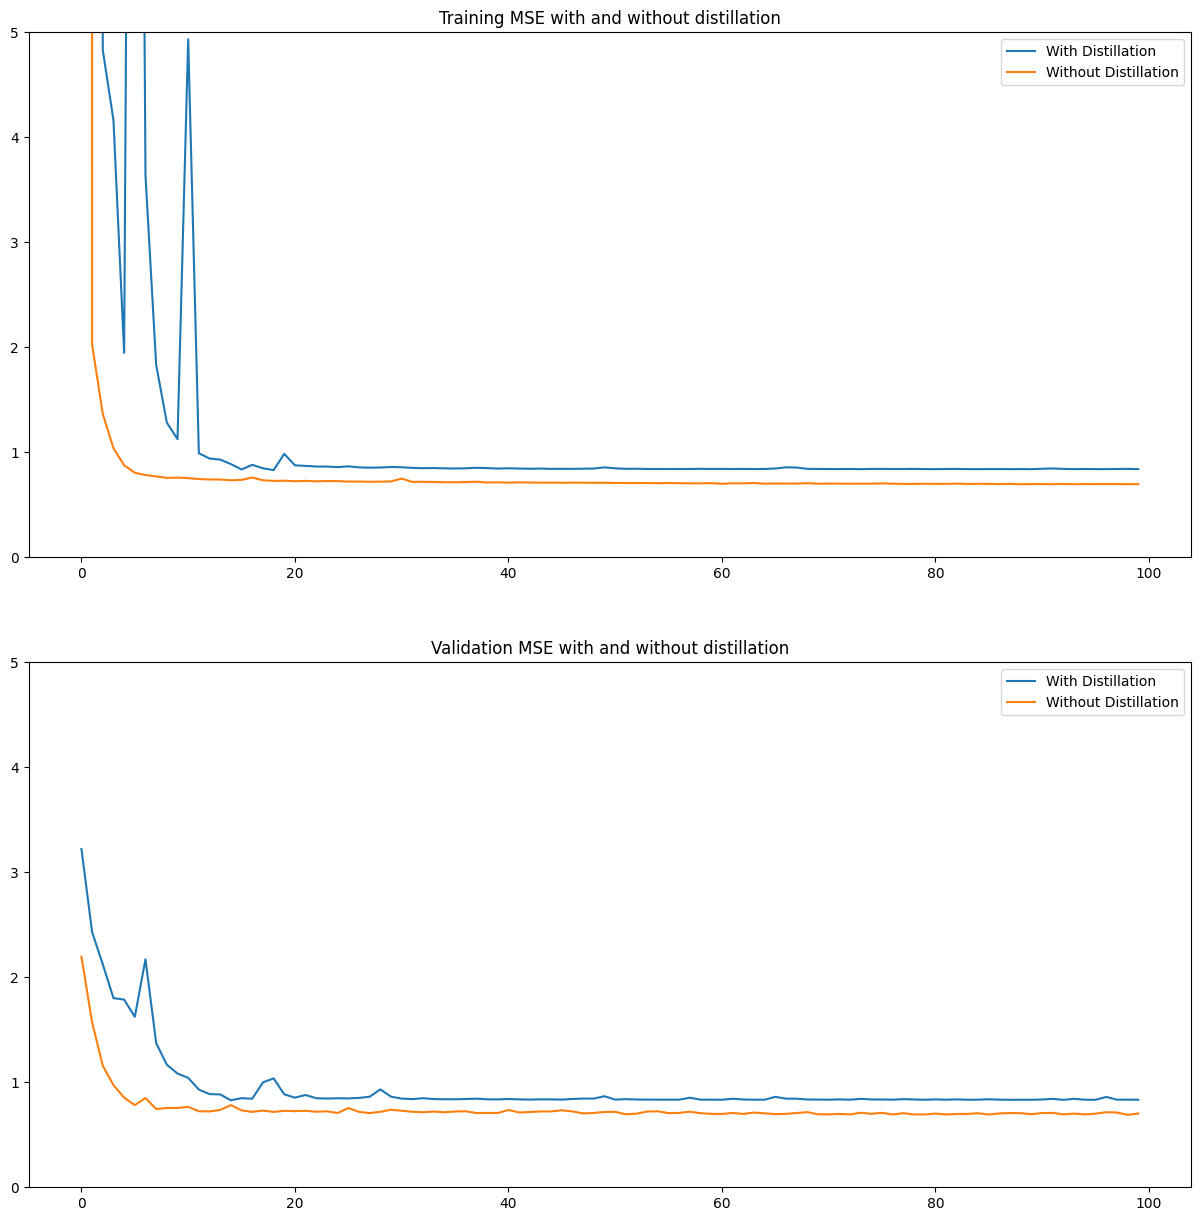

In [9]:
fig, axs = plt.subplots(2, 1, figsize=(15,15))

x = range(0, number_of_epochs)

# Compute the average on all folds for every epochs for training data
train_mse_with_distillation = np.mean([d['mse'] for d in train_val_results_with_distillation], 0)
train_mse_without_distillation = np.mean([d['mse'] for d in train_val_results_without_distillation], 0)

# Get the MSE for the training dataset
train_with_distillation_mse_last_epochs = [fold[-1:] for fold in [d['mse'] for d in train_val_results_with_distillation]]
train_without_distillation_mse_last_epochs = [fold[-1:] for fold in [d['mse'] for d in train_val_results_without_distillation]]

train_with_distillation_mse_std = np.std(train_with_distillation_mse_last_epochs)
train_without_distillation_mse_std = np.std(train_without_distillation_mse_last_epochs)


# Compute the average on all folds for every epochs for validation data
val_mse_with_distillation = np.mean([d['val_mse'] for d in train_val_results_with_distillation], 0)
val_mse_without_distillation = np.mean([d['val_mse'] for d in train_val_results_without_distillation], 0)

# Get the MSE for valiation dataset
val_with_distillation_mse_last_epochs = [fold[-1:] for fold in [d['mse'] for d in train_val_results_with_distillation]]
val_without_distillation_mse_last_epochs = [fold[-1:] for fold in [d['val_mse'] for d in train_val_results_without_distillation]]

val_with_distillation_mse_stds = np.std(val_with_distillation_mse_last_epochs)
val_without_distillation_mse_stds = np.std(val_without_distillation_mse_last_epochs)


# Traning results
axs[0].plot(x, train_mse_with_distillation) 
axs[0].plot(x, train_mse_without_distillation) 
axs[0].set_ylim(0, 5)
axs[0].title.set_text('Training MSE with and without distillation') 
axs[0].legend(['With Distillation', 'Without Distillation'])  

# Val results
axs[1].plot(x, val_mse_with_distillation) 
axs[1].plot(x, val_mse_without_distillation) 
axs[1].set_ylim(0, 5)
axs[1].title.set_text('Validation MSE with and without distillation') 
axs[1].legend(['With Distillation', 'Without Distillation'])

print(f"Validation mse with distillation {np.round(np.mean(val_with_distillation_mse_last_epochs), 4)} +- {np.round(val_with_distillation_mse_stds, 4)}")
#print(f"Test mse with disstillation {test_results_with_distillation}")

print(f"Validation mse without disstillation {np.round(np.mean(val_without_distillation_mse_last_epochs), 4)} +- {np.round(val_without_distillation_mse_stds, 4)}")
#print(f"Test mse without disstillation {test_results_without_distillation}")

Validation mse with distillation 0.6848 +- 0.2384
Validation mse without disstillation 0.625 +- 0.146


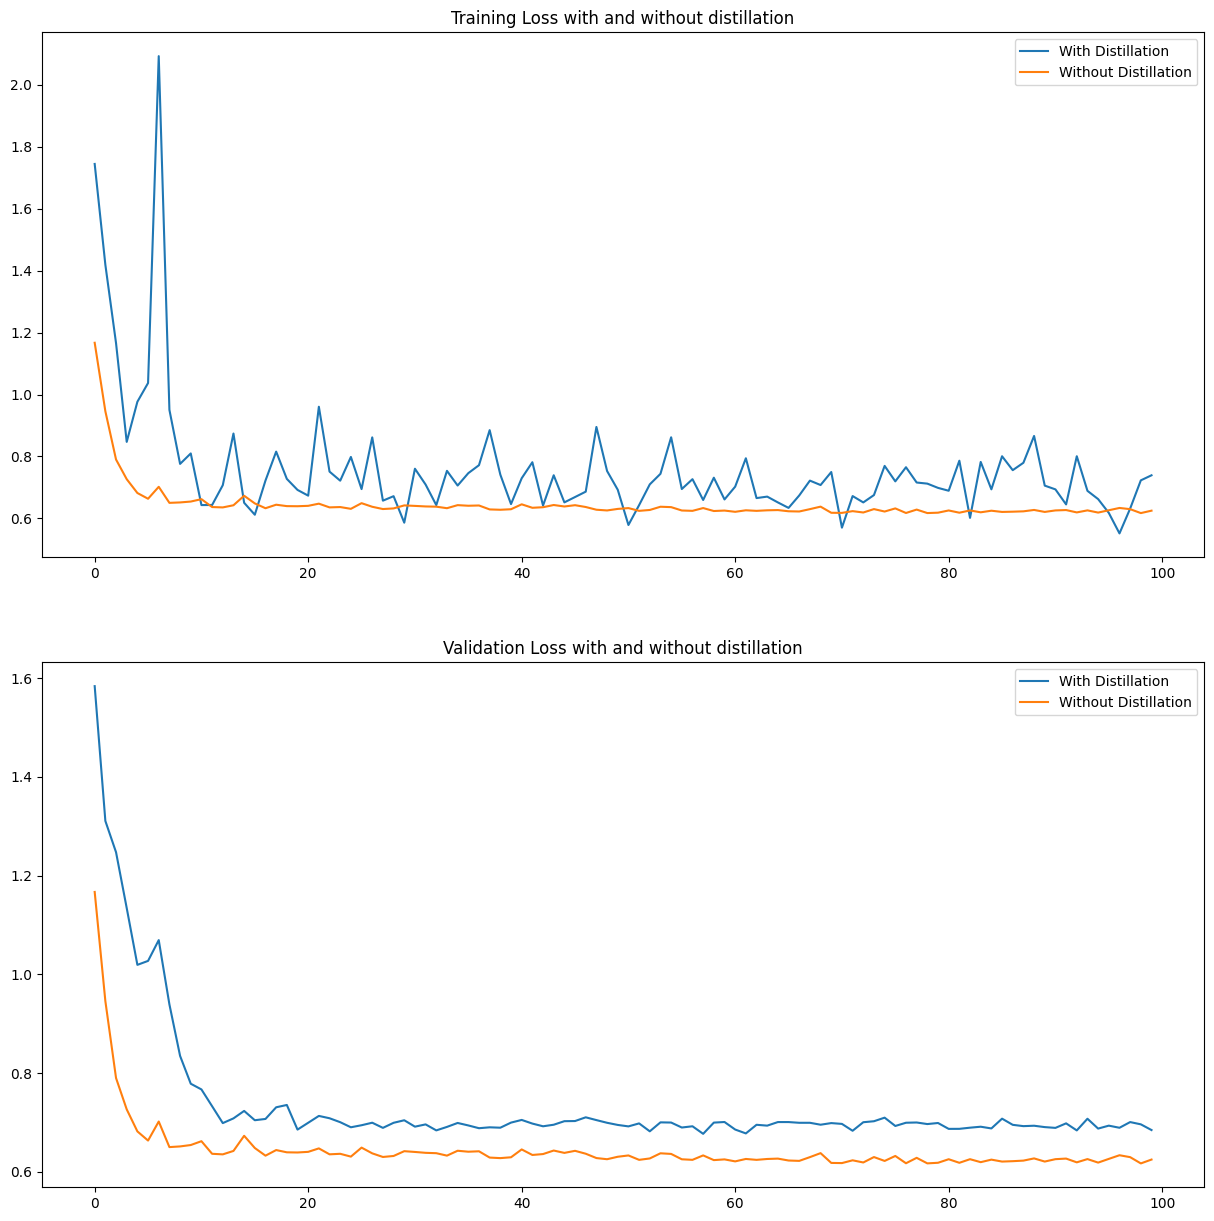

In [13]:
fig, axs = plt.subplots(2, 1, figsize=(15,15))

x = range(0, number_of_epochs)

# Compute the average on all folds for every epochs for training data
train_mse_with_distillation = np.mean([d['student_loss'] for d in train_val_results_with_distillation], 0)
train_mse_without_distillation = np.mean([d['val_loss'] for d in train_val_results_without_distillation], 0)

# Get the MSE for the training dataset
train_with_distillation_mse_last_epochs = [fold[-1:] for fold in [d['student_loss'] for d in train_val_results_with_distillation]]
train_without_distillation_mse_last_epochs = [fold[-1:] for fold in [d['loss'] for d in train_val_results_without_distillation]]

train_with_distillation_mse_std = np.std(train_with_distillation_mse_last_epochs)
train_without_distillation_mse_std = np.std(train_without_distillation_mse_last_epochs)


# Compute the average on all folds for every epochs for validation data
val_mse_with_distillation = np.mean([d['val_student_loss'] for d in train_val_results_with_distillation], 0)
val_mse_without_distillation = np.mean([d['val_loss'] for d in train_val_results_without_distillation], 0)

# Get the MSE for valiation dataset
val_with_distillation_mse_last_epochs = [fold[-1:] for fold in [d['val_student_loss'] for d in train_val_results_with_distillation]]
val_without_distillation_mse_last_epochs = [fold[-1:] for fold in [d['val_loss'] for d in train_val_results_without_distillation]]

val_with_distillation_mse_stds = np.std(val_with_distillation_mse_last_epochs)
val_without_distillation_mse_stds = np.std(val_without_distillation_mse_last_epochs)


# Traning results
axs[0].plot(x, train_mse_with_distillation) 
axs[0].plot(x, train_mse_without_distillation) 
#axs[0].set_ylim(0, 5)
axs[0].title.set_text('Training Loss with and without distillation') 
axs[0].legend(['With Distillation', 'Without Distillation'])  

# Val results
axs[1].plot(x, val_mse_with_distillation) 
axs[1].plot(x, val_mse_without_distillation) 
#axs[1].set_ylim(0, 5)
axs[1].title.set_text('Validation Loss with and without distillation') 
axs[1].legend(['With Distillation', 'Without Distillation'])

print(f"Validation mse with distillation {np.round(np.mean(val_with_distillation_mse_last_epochs), 4)} +- {np.round(val_with_distillation_mse_stds, 4)}")

print(f"Validation mse without disstillation {np.round(np.mean(val_without_distillation_mse_last_epochs), 4)} +- {np.round(val_without_distillation_mse_stds, 4)}")

In [11]:
# Train again on the entire traning set and then test
studnet_model = buildStudentModel()
studnet_model_without_distillation = keras.models.clone_model(studnet_model)

distiller = Distiller.Distiller(student=studnet_model, teacher=teacher_model)
distiller.compile(
    optimizer=keras.optimizers.Adam(),
    metrics=['mse', 'mae', 'mape'],
    student_loss_fn=tf.keras.losses.MeanAbsoluteError(),
    distillation_loss_fn=distiller.mse_distillation_loss_fucntion,
    alpha=0.1,
    temperature=10        
)
# Retrain both models
distiller.fit(x_train, y_train, epochs=number_of_epochs)

studnet_model_without_distillation.compile(
    optimizer=keras.optimizers.Adam(),
    loss=tf.keras.losses.MeanAbsoluteError(),
    metrics=['mse', 'mae', 'mape'],
)
studnet_model_without_distillation.fit(x_train, y_train, epochs=number_of_epochs)
    
# Evaluate the models onb the test data when the training is complete    
# Evaluate student on test dataset
test_results_with_distillation = distiller.evaluate(x_test, y_test, return_dict=True)
test_results_without_distillation = studnet_model_without_distillation.evaluate(x_test, y_test, return_dict=True)

Epoch 1/100
492/492 [==============================] - 2s 3ms/step - mse: 497.0027 - mae: 3.2000 - mape: 179.5341 - student_loss: 3.1952 - distillation_loss: 494.7324
Epoch 2/100
492/492 [==============================] - 1s 2ms/step - mse: 4.4155 - mae: 1.8611 - mape: 95.2856 - student_loss: 1.8617 - distillation_loss: 3.9517
Epoch 3/100
492/492 [==============================] - 1s 2ms/step - mse: 4.0921 - mae: 1.7721 - mape: 89.1838 - student_loss: 1.7727 - distillation_loss: 3.6359
Epoch 4/100
492/492 [==============================] - 1s 2ms/step - mse: 3.6893 - mae: 1.6542 - mape: 81.1046 - student_loss: 1.6543 - distillation_loss: 3.2287
Epoch 5/100
492/492 [==============================] - 1s 2ms/step - mse: 3.2337 - mae: 1.5105 - mape: 71.4096 - student_loss: 1.5091 - distillation_loss: 2.7748
Epoch 6/100
492/492 [==============================] - 1s 2ms/step - mse: 2.7584 - mae: 1.3487 - mape: 61.0400 - student_loss: 1.3498 - distillation_loss: 2.3052
Epoch 7/100
492/492 [==

492/492 [==============================] - 1s 2ms/step - mse: 0.9518 - mae: 0.7815 - mape: 55.9857 - student_loss: 0.7812 - distillation_loss: 0.5137
Epoch 52/100
492/492 [==============================] - 1s 2ms/step - mse: 0.9517 - mae: 0.7812 - mape: 55.9310 - student_loss: 0.7816 - distillation_loss: 0.5142
Epoch 53/100
492/492 [==============================] - 1s 2ms/step - mse: 0.9516 - mae: 0.7822 - mape: 56.1703 - student_loss: 0.7819 - distillation_loss: 0.5135
Epoch 54/100
492/492 [==============================] - 1s 2ms/step - mse: 0.9516 - mae: 0.7818 - mape: 56.0811 - student_loss: 0.7818 - distillation_loss: 0.5156
Epoch 55/100
492/492 [==============================] - 1s 2ms/step - mse: 0.9517 - mae: 0.7814 - mape: 55.9688 - student_loss: 0.7812 - distillation_loss: 0.5131
Epoch 56/100
492/492 [==============================] - 1s 2ms/step - mse: 0.9517 - mae: 0.7816 - mape: 56.0364 - student_loss: 0.7819 - distillation_loss: 0.5136
Epoch 57/100
492/492 [=============

492/492 [==============================] - 1s 2ms/step - loss: 3.9668 - mse: 1595.0116 - mae: 3.9668 - mape: 261.8351
Epoch 2/100
492/492 [==============================] - 1s 2ms/step - loss: 0.6532 - mse: 0.7271 - mae: 0.6532 - mape: 42.2032
Epoch 3/100
492/492 [==============================] - 1s 2ms/step - loss: 0.5832 - mse: 0.6237 - mae: 0.5832 - mape: 35.7461
Epoch 4/100
492/492 [==============================] - 1s 2ms/step - loss: 0.5745 - mse: 0.5950 - mae: 0.5745 - mape: 34.9200
Epoch 5/100
492/492 [==============================] - 1s 2ms/step - loss: 0.5689 - mse: 0.5829 - mae: 0.5689 - mape: 34.5245
Epoch 6/100
492/492 [==============================] - 1s 2ms/step - loss: 0.5672 - mse: 0.5875 - mae: 0.5672 - mape: 34.5791
Epoch 7/100
492/492 [==============================] - 1s 2ms/step - loss: 0.5571 - mse: 0.5594 - mae: 0.5571 - mape: 33.8935
Epoch 8/100
492/492 [==============================] - 1s 2ms/step - loss: 0.5396 - mse: 0.5267 - mae: 0.5396 - mape: 32.6653


492/492 [==============================] - 1s 2ms/step - loss: 0.4778 - mse: 0.4204 - mae: 0.4778 - mape: 28.9356
Epoch 66/100
492/492 [==============================] - 1s 2ms/step - loss: 0.4715 - mse: 0.4103 - mae: 0.4715 - mape: 28.6092
Epoch 67/100
492/492 [==============================] - 1s 2ms/step - loss: 0.4714 - mse: 0.4111 - mae: 0.4714 - mape: 28.5434
Epoch 68/100
492/492 [==============================] - 1s 2ms/step - loss: 0.4709 - mse: 0.4082 - mae: 0.4709 - mape: 28.5005
Epoch 69/100
492/492 [==============================] - 1s 2ms/step - loss: 0.4740 - mse: 0.4160 - mae: 0.4740 - mape: 28.7827
Epoch 70/100
492/492 [==============================] - 1s 2ms/step - loss: 0.4780 - mse: 0.4226 - mae: 0.4780 - mape: 29.0502
Epoch 71/100
492/492 [==============================] - 1s 2ms/step - loss: 0.4694 - mse: 0.4063 - mae: 0.4694 - mape: 28.5350
Epoch 72/100
492/492 [==============================] - 1s 2ms/step - loss: 0.4703 - mse: 0.4096 - mae: 0.4703 - mape: 28.45

In [12]:
print(f"Test mse with disstillation {test_results_with_distillation}")
print(f"Test mse without disstillation {test_results_without_distillation}")

Test mse with disstillation {'mse': 1.3309773206710815, 'mae': 0.878064751625061, 'mape': 56.7020149230957, 'student_loss': 0.7909102439880371}
Test mse without disstillation {'loss': 0.5000376105308533, 'mse': 0.5170630216598511, 'mae': 0.5000376105308533, 'mape': 26.999401092529297}


In [22]:
# # Save the model to load in future
# %mkdir Exp1Models
#%mkdir Exp1Models/Exp2

# studnet_model.save('Exp1Models/Exp2/studnet_model')
# studnet_model_without_distillation.save('Exp1Models/Exp2/studnet_model_without_distillation')

The syntax of the command is incorrect.


INFO:tensorflow:Assets written to: Exp1Models/Exp2/studnet_model\assets


INFO:tensorflow:Assets written to: Exp1Models/Exp2/studnet_model\assets


INFO:tensorflow:Assets written to: Exp1Models/Exp2/studnet_model_without_distillation\assets


INFO:tensorflow:Assets written to: Exp1Models/Exp2/studnet_model_without_distillation\assets
